In [ ]:
#Distinguere le categorie dataset, come?
#Nomi Features
#Numero o tipo features
#Metadati!
#Metodi di raccolta


In [1]:
#Test con 50 DATASET

#Carico il json

import json
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

# Carica i dati dal JSON
with open('export.json', 'r') as file:
    data = json.load(file)
   

In [77]:
#data

In [54]:
#FUNZIONE NORMALIZZAZIONE

import re
#from nltk.corpus import stopwords
import nltk

#stop_words = set(stopwords.words('english'))

#funzione che normalizza features: tutto lower + rimuove simboli strani
def normalize_feature(feature):
    # Rimozione di simboli strani e sostituzione degli spazi con underscore
    new_feature = re.sub(r'[^a-zA-Z_]', '', feature)
    # Sostituisci underscore con spazio
    new_feature = new_feature.replace('_', ' ')    
    
    # Inserisci spazio tra lettere maiuscole e minuscole
    new_feature = re.sub(r'([a-z])([A-Z])', r'\1 \2', new_feature)
    #gestisce caso 2 maiuscole
    new_feature = re.sub(r'([A-Z])([A-Z][a-z])', r'\1 \2', new_feature)
    
    # Trasformazione in minuscolo
    new_feature = new_feature.lower()
    #Rimuove eventuali spazi di troppo e iniziali finali
    new_feature = new_feature.strip()
    new_feature = re.sub(r'\s+', ' ', new_feature)
    return new_feature
       

In [60]:
#COSTRUZIONE STRINGA UNICA CON FEATURES SEPARATE DA SPAZIO:
#NORMALIZZATE (NO SIMBOLI STRANI E NUMERI, SEPARATI DA UNDERSCORE O LETTERA MAIUSCOLA-MINUSCOLA, POI RESI TUTTI MINUSCOLI)
#TOLTI I DOPPIONI
#SI LIMITA A PRIME N FEATURES, E A UNA LUNGHEZZA MASSIMA DELLA STRINGA TOTALE

#Limitazioni 
limit_len_s = 200 #lunghezza stringhe
limit_n_features = 20 #numero features

#il primo elemento nella lista è la categoria e viene tolta, le altre sono features
#features to string
set_features = []
categories = []

#exclude = ['age', 'gender', 'sex', 'id', 'value', 'height', 'weight']

for dataset in data:
    s = ""
    first_element_added = False  # per tenere traccia del primo elemento
    features_selected = data[dataset][0:limit_n_features] #prendo prime n features
    #applico normalizzazine
    for i in range(0, len(features_selected)):
        features_selected[i] = normalize_feature(features_selected[i])
    #rimuovo duplicati
    unique_elements = []
    seen = set()
    for el in features_selected:
        normalized = normalize_feature(el)
        if normalized not in seen:
            unique_elements.append(el)
            seen.add(normalized)   
    features_selected = unique_elements       
    #print(features_selected)
    for el in features_selected:
        if first_element_added:
            # Concatena gli elementi successivi fino a raggiungere 200 caratteri
            if len(s + el + " ") <= limit_len_s:
                #if el not in exclude:
                s = s + el + " "  # Concatena gli elementi successivi
            else:
                break  # Esci dal loop se la lunghezza supera i 200 caratteri
        else:
            categories.append(el)  # Aggiungi il primo elemento a categories
            first_element_added = True
            
    set_features.append(s.rstrip()) #Toglie spazio alla fine

    
set_features[0:5]

['gender ethnic group parent educ lunch type test prep parent marital status practice sport is first child nr siblings transport means wkly study hours math score reading score writing score',
 'countriesandareas latitude longitude oosr pre primary age male oosr pre primary age female oosr primary age male oosr primary age female oosr lower secondary age male oosr lower secondary age female',
 'index location indicator subject time value',
 'id student age sex high school type scholarship additional work sports activity transportation weekly study hours attendance reading notes listening in class project work grade',
 'student id school sex age address type family size parent status mother education father education mother job father job school choice reason guardian travel time study time class failures']

In [61]:
#quante e quali categorie?
print(set(categories))

{'healthcare', 'education', 'sport', 'music'}


In [62]:
#DIZIONARIO COSTRUITO, SERVE PER CAPIRE SE STA FUNZIONANDO CON LE CATEGORIE CHE MI ATTENDO
#!! costruisco un dizionario con ciascuna stringa come chiave associata alla categoria. 
#!!costoso, da valutare se fare in un colpo solo prima
# Verifica se le liste hanno la stessa lunghezza
if len(categories) == len(set_features):
    dictionary = {}

    for i in range(len(categories)):
        stringa = set_features[i]
        categoria = categories[i]

        if stringa not in dictionary:
            dictionary[stringa] = categoria

    #print(dictionary)
else:
    print("Le liste non hanno la stessa lunghezza")


In [76]:
#TF-IDF

from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

#Quante features con tf idf più alto prendo?
len_mainfeatures = 5


# Creazione del vettore TF-IDF
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(set_features)

# Ottieni i nomi delle feature (termini)
feature_names = vectorizer.get_feature_names_out()

# Inizializza un vettore per i termini più significativi
top_terms = []

# Per ogni documento, identifica i primi tre termini più significativi
for i, doc in enumerate(set_features):
    # Ottieni gli indici dei termini con TF-IDF più alto
    top_indices = tfidf_matrix[i].toarray().argsort()[0][::-1]
    # Filtra i termini con valore TF-IDF zero e prendi i primi tre
    nonzero_indices = [index for index in top_indices if tfidf_matrix[i, index] != 0][:len_mainfeatures]
    # Ottieni i termini e i relativi TF-IDF
    terms_tfidf = [(feature_names[index], tfidf_matrix[i, index]) for index in nonzero_indices]
    # Aggiungi i termini più significativi al vettore
    top_terms.append(terms_tfidf)

# Mostra i termini più significativi per ogni documento
for i, terms in enumerate(top_terms):
    print(f"Termini più significativi per il documento {i + 1}: " + categories[i])
    for term, tfidf_score in terms:
        print(f"- Termine: {term}, TF-IDF: {tfidf_score}")

# Ora puoi utilizzare la variabile top_terms che contiene i termini più significativi per ogni documento


Termini più significativi per il documento 1: education
- Termine: score, TF-IDF: 0.47197356441989535
- Termine: parent, TF-IDF: 0.3146490429465969
- Termine: group, TF-IDF: 0.17452752592244936
- Termine: ethnic, TF-IDF: 0.17452752592244936
- Termine: sport, TF-IDF: 0.17452752592244936
Termini più significativi per il documento 2: education
- Termine: oosr, TF-IDF: 0.6309536354966557
- Termine: primary, TF-IDF: 0.4206357569977705
- Termine: age, TF-IDF: 0.3119974382052644
- Termine: female, TF-IDF: 0.28438058195031407
- Termine: male, TF-IDF: 0.28438058195031407
Termini più significativi per il documento 3: education
- Termine: indicator, TF-IDF: 0.4424571872623212
- Termine: location, TF-IDF: 0.4424571872623212
- Termine: subject, TF-IDF: 0.4424571872623212
- Termine: index, TF-IDF: 0.39884462287855355
- Termine: time, TF-IDF: 0.36790101600347813
Termini più significativi per il documento 4: education
- Termine: work, TF-IDF: 0.38823703371145063
- Termine: project, TF-IDF: 0.215344843

In [ ]:
#CLUSTERING

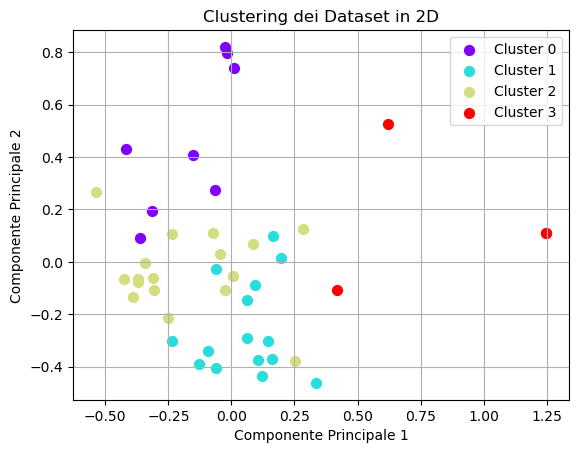

In [51]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Tokenizzazione delle stringhe e creazione di rappresentazioni vettoriali
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(set_features)

# Calcolo della similarità tra dataset basata sulla similarità del coseno
similarity_matrix = cosine_similarity(X)
#print(similarity_matrix)

# Applicazione di DBSCAN per raggruppare i dataset
#eps = 1.2  # Distanza massima tra due campioni per appartenere allo stesso cluster
#min_samples = 2  # Numero minimo di campioni in un vicinato per formare un cluster
#dbscan = DBSCAN(eps=eps, min_samples=min_samples)
#clusters = dbscan.fit_predict(similarity_matrix)

# Applicazione di K-Means per raggruppare i dataset
num_clusters = len(set(categories))  # Numero di cluster desiderati = numero categorie
kmeans = KMeans(n_clusters=num_clusters)
clusters = kmeans.fit_predict(similarity_matrix)


# Riduzione dimensionale con PCA a 2 componenti
pca = PCA(n_components=2)
X_pca = pca.fit_transform(similarity_matrix)

# Plot in 2D dei cluster
unique_clusters = np.unique(clusters)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_clusters)))

for cluster_label, color in zip(unique_clusters, colors):
    cluster_mask = (clusters == cluster_label)
    plt.scatter(
        X_pca[cluster_mask, 0],
        X_pca[cluster_mask, 1],
        label=f'Cluster {cluster_label}',
        color=color,
        s=50
    )

# Impostazioni del plot
plt.title('Clustering dei Dataset in 2D')
plt.xlabel('Componente Principale 1')
plt.ylabel('Componente Principale 2')
plt.legend()
plt.grid(True)
plt.show()

In [52]:
# Organizzazione dei dataset per cluster
dataset_per_cluster = {}
for i, cluster_label in enumerate(clusters):
    if cluster_label not in dataset_per_cluster:
        dataset_per_cluster[cluster_label] = []
    dataset_per_cluster[cluster_label].append(set_features[i])

# Visualizzazione dei dataset per ciascun cluster
for cluster_label, datasets in dataset_per_cluster.items():
    print(f"Cluster {cluster_label}:")
    for dataset in datasets:
        print(f"categoria: {dictionary[dataset]}")
        print(f"features: {dataset}")
        print()
    print("-----")

Cluster 1:
categoria: education
features: gender ethnic group parent educ lunch type test prep parent marital status practice sport is first child nr siblings transport means wkly study hours math score reading score writing score

categoria: education
features: countriesandareas latitude longitude oosr pre primary age male oosr pre primary age female oosr primary age male oosr primary age female oosr lower secondary age male oosr lower secondary age female

categoria: education
features: id student age sex high school type scholarship additional work sports activity transportation weekly study hours attendance reading notes listening in class project work grade

categoria: education
features: student id school sex age address type family size parent status mother education father education mother job father job school choice reason guardian travel time study time class failures

categoria: healthcare
features: patient id age gender protein tumour stage histology e rstatus p rstatus he

In [ ]:
#for dataset in dataset_per_cluster[0]:
#    print(f"categoria: {dictionary[dataset]}")
#    print(f"features: {dataset}")
#    print()

In [53]:
# Visualizzazione solo categorie
for cluster_label, datasets in dataset_per_cluster.items():
    print(f"Cluster {cluster_label}:")
    for dataset in datasets:
        print(f"{dictionary[dataset]}", end=' ')
    print()

Cluster 1:
education education education education healthcare healthcare healthcare healthcare healthcare healthcare healthcare healthcare sport sport sport 
Cluster 2:
education healthcare healthcare healthcare healthcare healthcare healthcare music music music music music sport sport sport sport sport 
Cluster 0:
music music music music music music sport sport 
Cluster 3:
sport sport sport sport 


In [ ]:
# Riduzione dimensionale con PCA a 3 componenti
pca = PCA(n_components=3)
X_pca = pca.fit_transform(similarity_matrix)

# Plot in 3D dei cluster
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Estrai punti per ciascun cluster
unique_clusters = np.unique(clusters)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_clusters)))

for cluster_label, color in zip(unique_clusters, colors):
    cluster_mask = (clusters == cluster_label)
    ax.scatter(
        X_pca[cluster_mask, 0],
        X_pca[cluster_mask, 1],
        X_pca[cluster_mask, 2],
        label=f'Cluster {cluster_label}',
        color=color,
        s=50
    )

# Impostazioni del plot
ax.set_title('Clustering dei Dataset in 3D')
ax.set_xlabel('Componente Principale 1')
ax.set_ylabel('Componente Principale 2')
ax.set_zlabel('Componente Principale 3')
ax.legend()
plt.show()

In [ ]:
#WORD2VEC


from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import gensim.downloader as api

model = api.load("word2vec-google-news-300")
